<a href="https://colab.research.google.com/github/1024ent/1024ent/blob/main/heart_failure_classification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🫀 Heart Failure Clinical Records Analysis  
**Author:** *[LOO HUI KIE]*  
**Date:** *[16/05/2025]*

---

### 📚 Import Libraries  
> All necessary libraries are imported here for data handling, visualization, and modeling. Keeping imports at the top of the notebook ensures clarity and maintainability.

```python
"""Heart Failure Clinical Records Analysis Pipeline"""

In [ ]:
# 📦 Optional: Install required packages (uncomment if not already installed)
!pip install ucimlrepo
!pip install tensorflow
!pip install imbalanced-learn

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global styles for visualizations
sns.set_theme(style="whitegrid", palette="husl")
pd.set_option('display.max_columns', 50)

### 📥 1. Data Loading  
> Load the dataset to begin analysis. Ensure the data is correctly formatted and clean before proceeding to exploration and modeling.


In [ ]:
def load_data():
    """
    Fetch and return heart failure dataset with validation.
    Falls back to Google Drive if UCI repository is unavailable.
    """
    try:
        from ucimlrepo import fetch_ucirepo

        print("🔄 Trying to fetch dataset from UCI repository...")
        heart_failure = fetch_ucirepo(id=519)

        # Validate data structure
        assert hasattr(heart_failure, 'data'), "Data object not found in response"
        assert not heart_failure.data.features.empty, "Features dataframe is empty"
        assert not heart_failure.data.targets.empty, "Targets dataframe is empty"

        print("✅ Loaded data from UCI repository.")
        return heart_failure.data.features, heart_failure.data.targets.squeeze()

    except Exception as e:
        print(f"⚠️ UCI repo failed: {e}")
        print("📥 Falling back to Google Drive...")

        try:
            import gdown

            # Google Drive file ID from the link
            file_id = "1hlZ-n5QYsm02FkUq87rVTLAKJoMMewEq"
            output_file = "heart_failure_backup.csv"

            # Download file
            if not os.path.exists(output_file):
                url = f"https://drive.google.com/uc?id={file_id}"
                gdown.download(url, output_file, quiet=False)

            # Load CSV
            df = pd.read_csv(output_file)

            # Assume last column is the target
            X = df.iloc[:, :-1]
            y = df.iloc[:, -1]

            print("✅ Loaded data from Google Drive.")
            return X, y

        except Exception as e2:
            print(f"❌ Failed to load data from Google Drive: {e2}")
            raise

# --- Usage ---
X, y = load_data()


🔄 Trying to fetch dataset from UCI repository...
⚠️ UCI repo failed: Error connecting to server
📥 Falling back to Google Drive...
✅ Loaded data from Google Drive.


### 🔍 2. Initial Data Inspection  
> Perform a preliminary check to understand the structure, types, and completeness of the dataset. This includes viewing sample entries, data types, and checking for missing values.


In [ ]:
from scipy import stats

def initial_inspection(data: pd.DataFrame, target: pd.Series):
    """Perform initial data exploration."""
    print("🔄 Performing initial data inspection...")

    # Create composite DataFrame
    df = data.assign(DEATH_EVENT=target)

    # Dataset metadata
    print(f"\n📦 Dataset Shape: {df.shape}")
    print("\n🔍 First 5 Rows:")
    display(df.head())

    # Structure information
    print("\n📝 Data Types:")
    print(df.dtypes)

    # Basic statistics
    print("\n📊 Descriptive Statistics:")
    display(df.describe(percentiles=[.25, .5, .75, .95]).T)

    return df

df = initial_inspection(X, y)


🔄 Performing initial data inspection...

📦 Dataset Shape: (299, 13)

🔍 First 5 Rows:


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1



📝 Data Types:
age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

📊 Descriptive Statistics:


,count,mean,std,min,25%,50%,75%,95%,max
age,299.0,60.833893,11.894809,40.0,51.0,60.0,70.0,82.0,95.0
anaemia,299.0,0.431438,0.496107,0.0,0.0,0.0,1.0,1.0,1.0
creatinine_phosphokinase,299.0,581.839465,970.287881,23.0,116.5,250.0,582.0,2263.0,7861.0
diabetes,299.0,0.418060,0.494067,0.0,0.0,0.0,1.0,1.0,1.0
ejection_fraction,299.0,38.083612,11.834841,14.0,30.0,38.0,45.0,60.0,80.0
high_blood_pressure,299.0,0.351171,0.478136,0.0,0.0,0.0,1.0,1.0,1.0
platelets,299.0,263358.029264,97804.236869,25100.0,212500.0,262000.0,303500.0,422500.0,850000.0
serum_creatinine,299.0,1.393880,1.034510,0.5,0.9,1.1,1.4,3.0,9.4
serum_sodium,299.0,136.625418,4.412477,113.0,134.0,137.0,140.0,144.0,148.0
sex,299.0,0.648829,0.478136,0.0,0.0,1.0,1.0,1.0,1.0


### 📊 Exploratory Data Analysis (EDA)

The function `perform_eda(df)` is used to explore the dataset and understand its characteristics through visualizations. It includes:

1. **Target Variable Distribution**
   - Shows the count of each category in the target column `DEATH_EVENT` using a bar chart.
   - Helps identify any class imbalance in the dataset.

2. **Correlation Matrix**
   - Computes the correlation between numerical features.
   - Displays a heatmap to reveal which features are strongly or weakly correlated.
   - Uses a mask to hide the upper triangle of the matrix for cleaner visualization.

3. **Feature Distribution Plots**
   - Selects all numerical columns except the target.
   - Plots histograms for each to understand the distribution (e.g., normal, skewed).

This step is useful to:
- Detect outliers or skewness,
- Identify redundant features (high correlation),
- Get an overview of the dataset before modeling.

✅ Run the analysis using:
```python
perform_eda(cleaned_df)




🔍 Performing EDA...


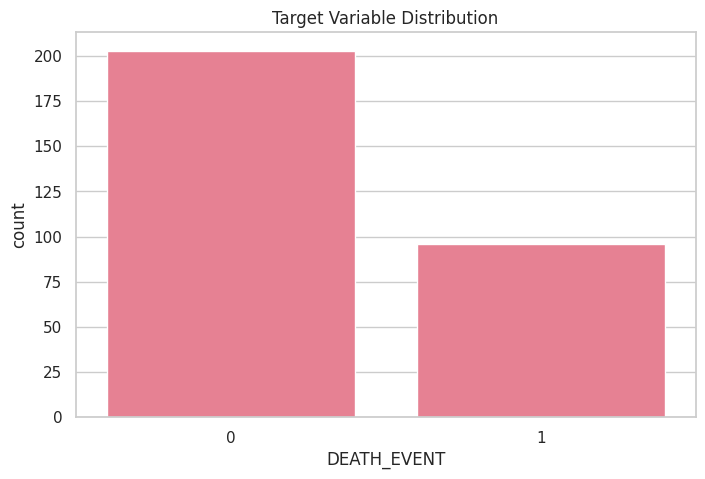

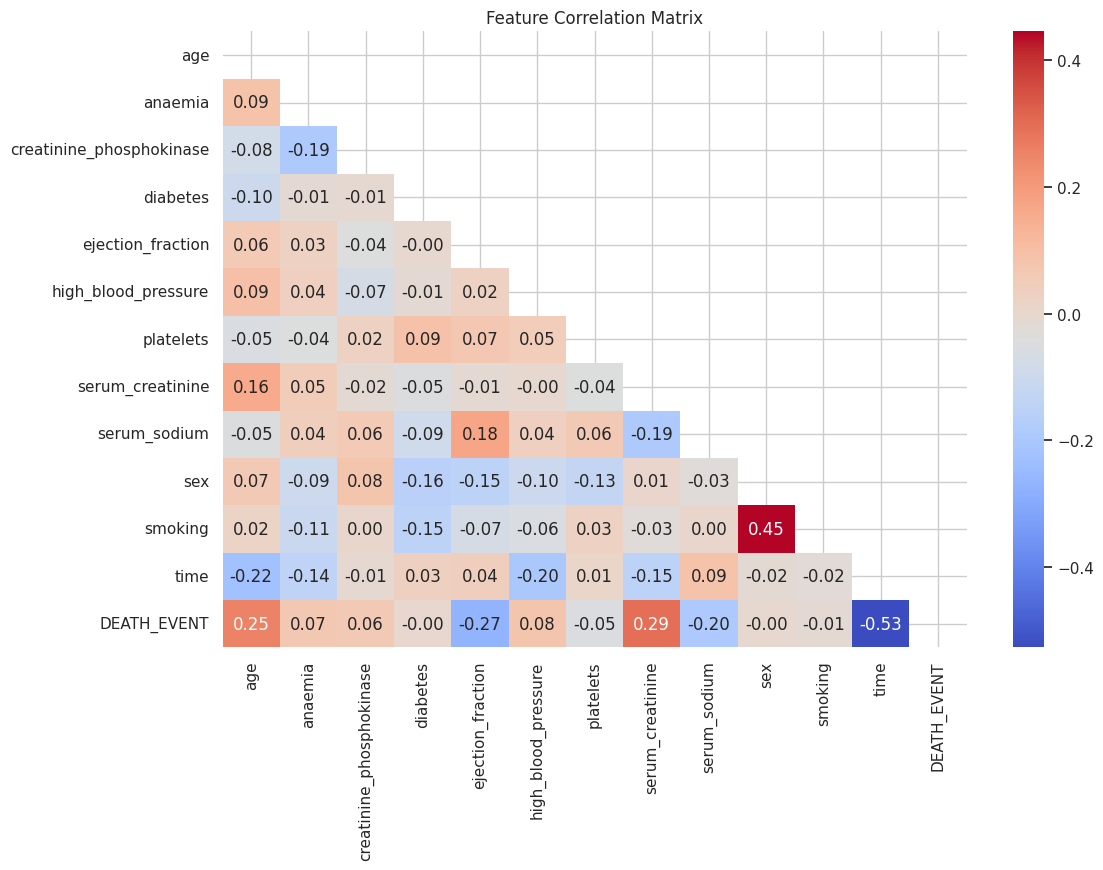

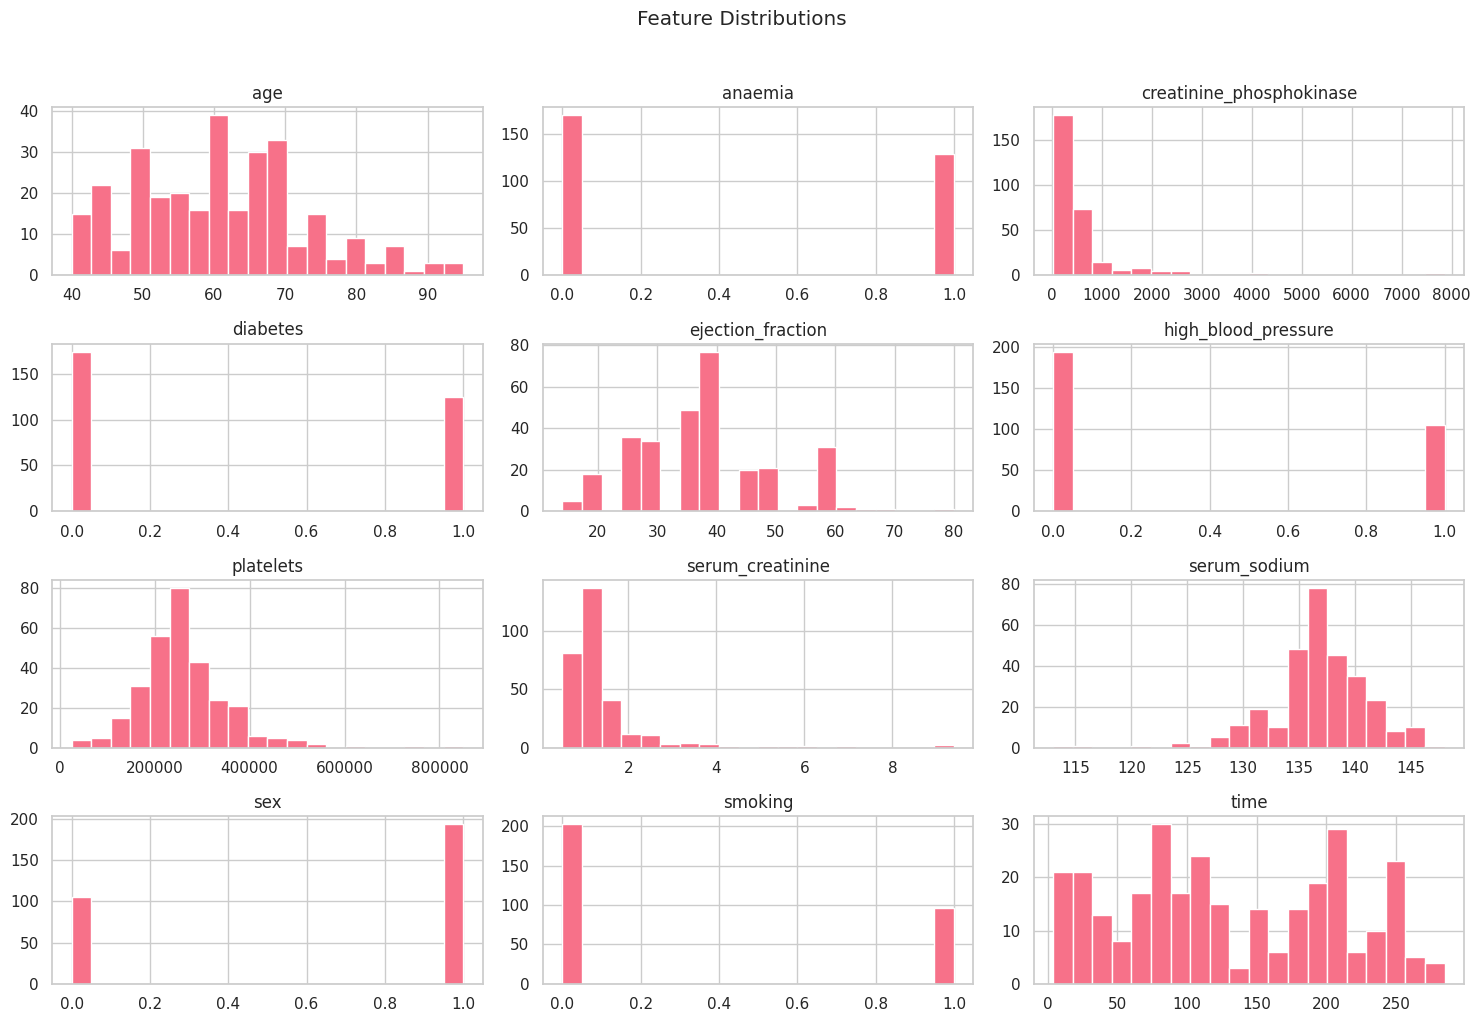


📊 Adding boxplots for numerical features...


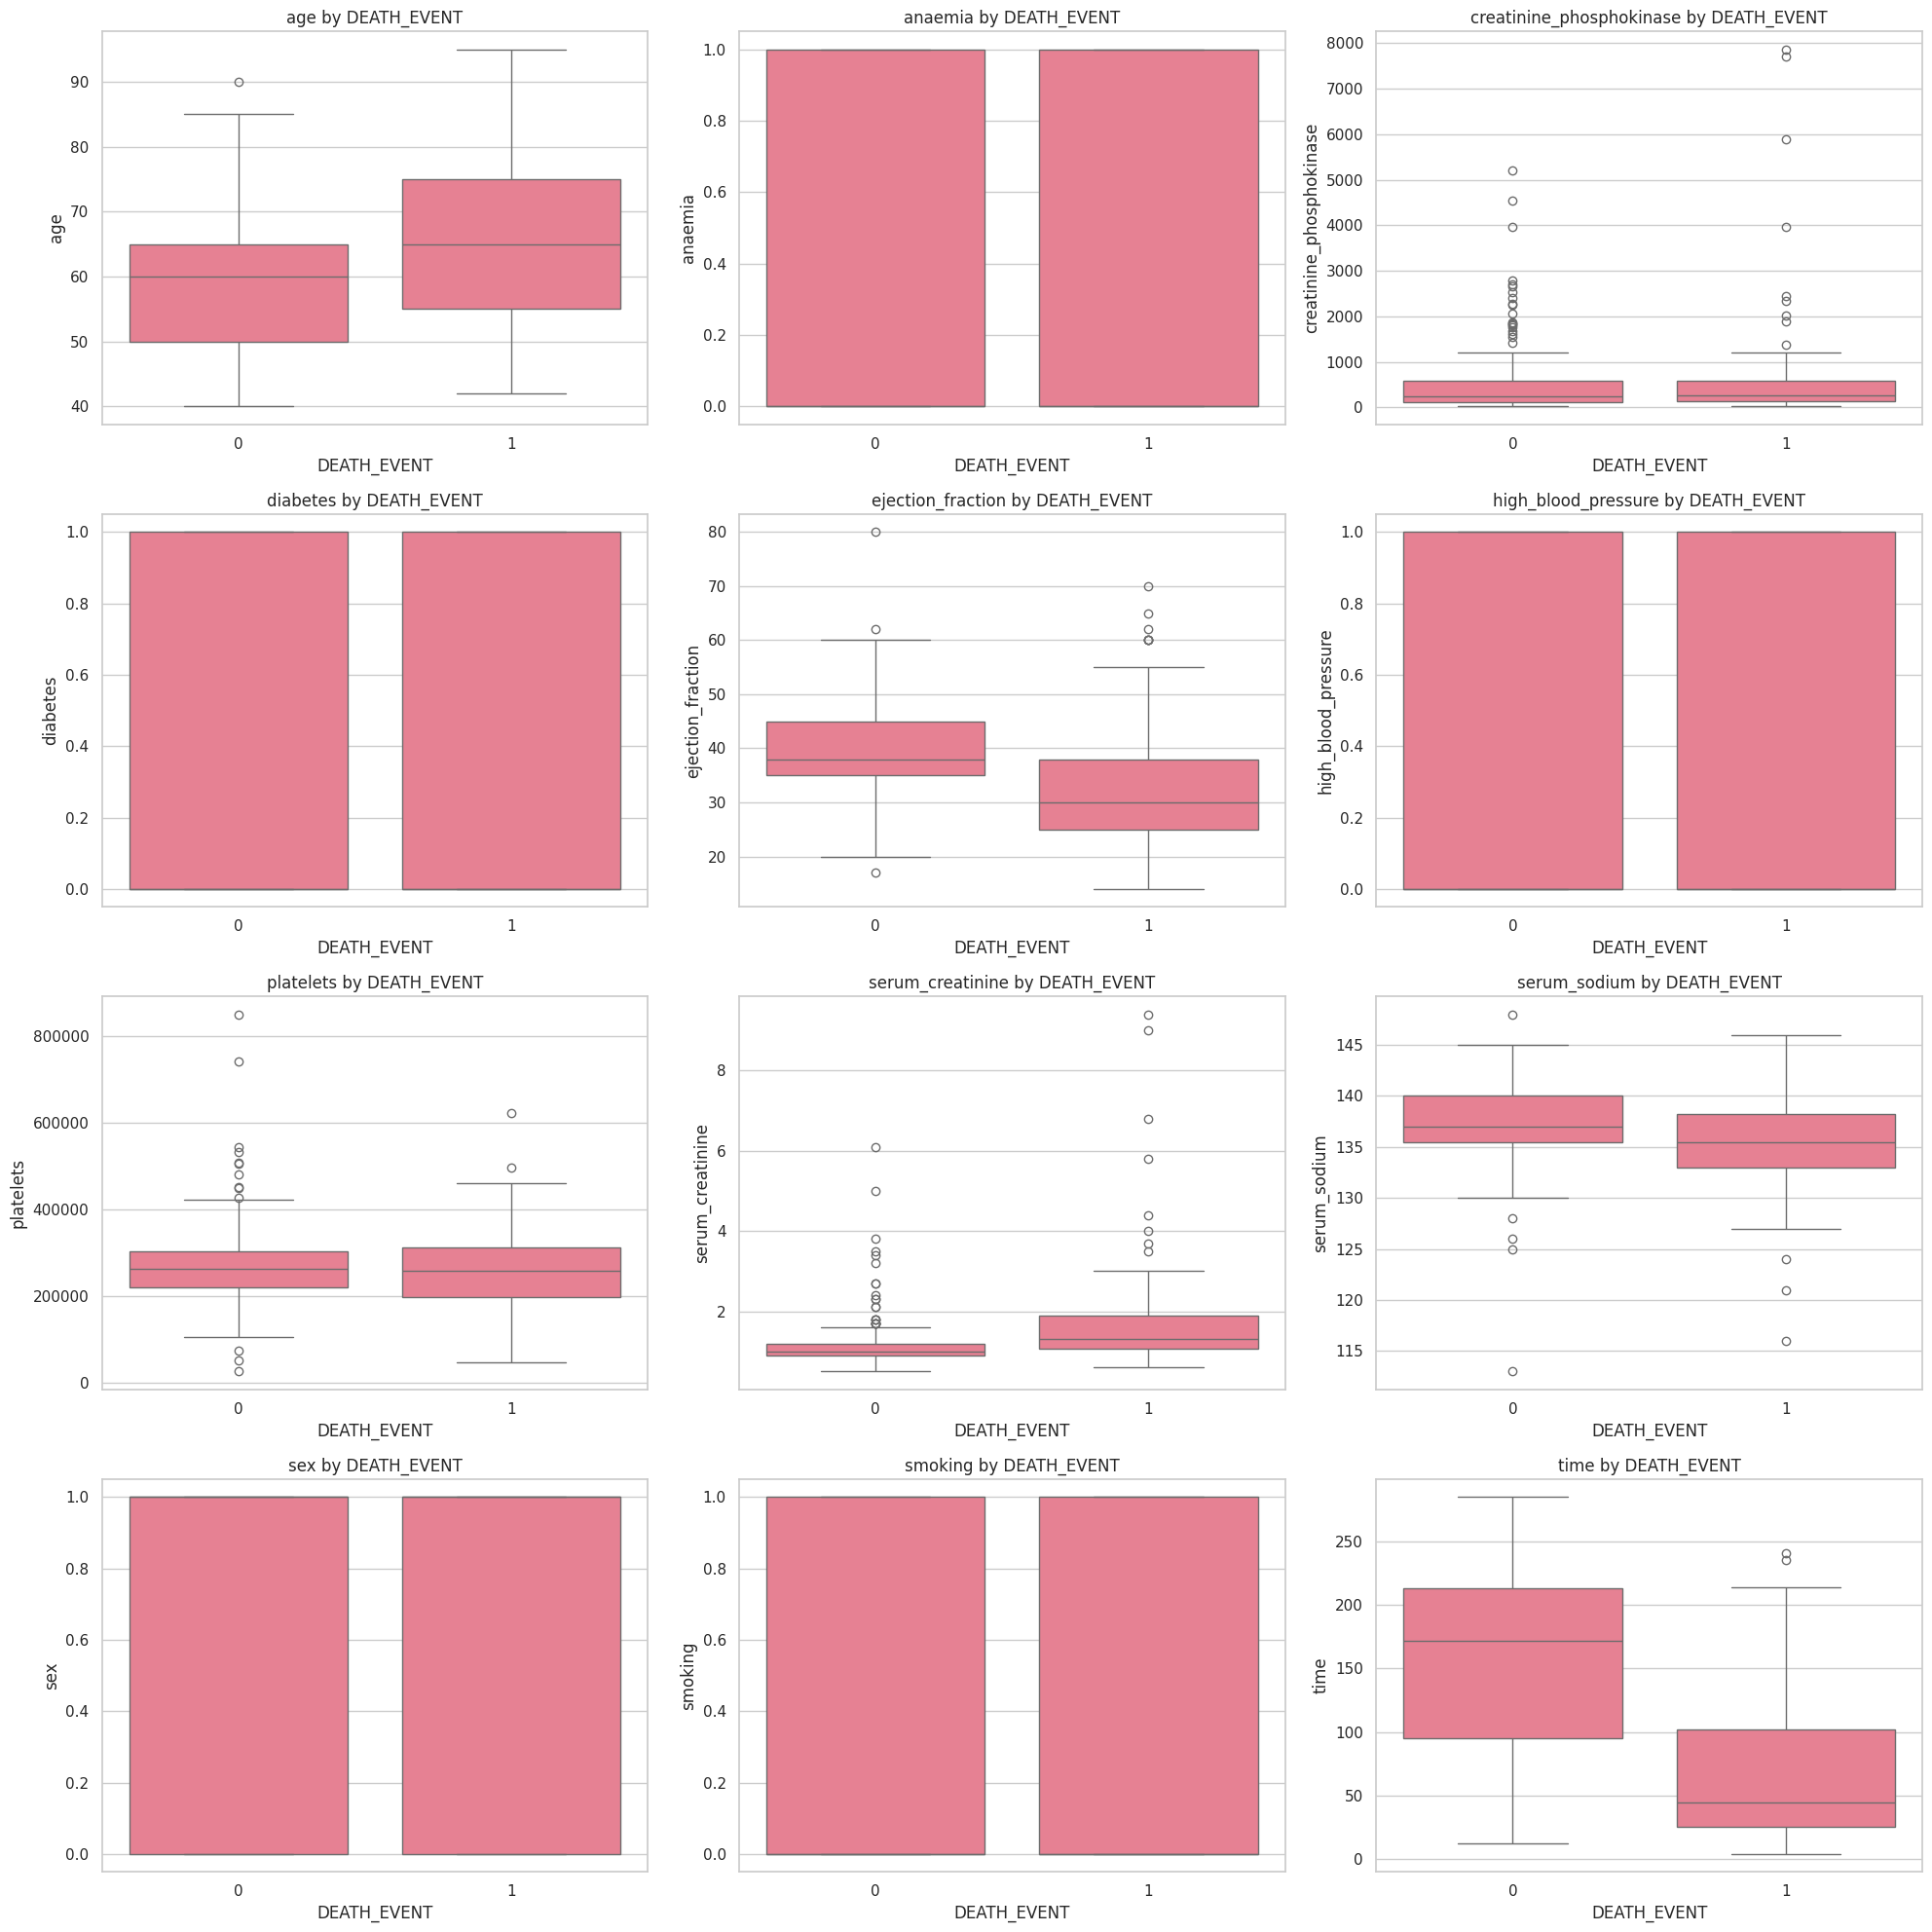

In [ ]:
def perform_eda(df: pd.DataFrame, target_col: str = 'DEATH_EVENT'):
    """
    Perform comprehensive exploratory data analysis (EDA):
    - Target distribution
    - Feature distributions (histograms)
    - Correlation matrix
    - Boxplots for all numerical features (new addition)
    """
    print("\n🔍 Performing EDA...")

    # 1. Target Distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x=target_col, data=df)
    plt.title("Target Variable Distribution")
    plt.show()

    # 2. Correlation Analysis
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        mask=np.triu(np.ones_like(corr_matrix, dtype=bool))
    )
    plt.title("Feature Correlation Matrix")
    plt.show()

    # 3. Histograms for Numerical Features
    numerical_features = df.select_dtypes(include=np.number).columns.drop(target_col)
    df[numerical_features].hist(figsize=(15, 10), bins=20)
    plt.suptitle("Feature Distributions", y=1.02)
    plt.tight_layout()
    plt.show()

    # 4. Boxplots for Numerical Features (NEW)
    print("\n📊 Adding boxplots for numerical features...")
    n_cols = 3
    n_rows = (len(numerical_features) + n_cols - 1) // n_cols
    plt.figure(figsize=(20, 5 * n_rows))

    for i, feature in enumerate(numerical_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(x=target_col, y=feature, data=df)
        plt.title(f'{feature} by {target_col}')

    plt.tight_layout()
    plt.show()

# Run EDA
perform_eda(df)

### 🧹 3. Data Cleaning  
> Handle missing values, remove duplicates, and correct data types to prepare the dataset for effective analysis and modeling. Clean data ensures more accurate and reliable results.


In [ ]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Perform data cleaning operations."""
    print("\n🧹 Cleaning data...")

    # Duplicates check
    duplicate_count = df.duplicated().sum()
    print(f"🔍 Found {duplicate_count} duplicates")
    if duplicate_count > 0:
        df = df.drop_duplicates()
        print("✅ Duplicates removed")

    # Missing values check
    missing_values = df.isna().sum()
    if missing_values.any():
        print("\n⚠️ Missing Values:")
        display(missing_values[missing_values > 0])
    else:
        print("\n✅ No missing values found")

    # Outlier detection using Z-score
    numeric_cols = df.select_dtypes(include=np.number).columns
    z_scores = np.abs(stats.zscore(df[numeric_cols]))
    outliers = (z_scores > 3).any(axis=1)
    print(f"\n📈 Found {outliers.sum()} potential outliers using Z-score (3σ)")

    return df

cleaned_df = clean_data(df)



🧹 Cleaning data...
🔍 Found 0 duplicates

✅ No missing values found

📈 Found 19 potential outliers using Z-score (3σ)


# 5. Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# --- Feature Selection ---
def select_features(df, target='DEATH_EVENT', k=10):
    X = df.drop(columns=[target])
    y = df[target]

    # Select top k features
    selector = SelectKBest(f_classif, k=k)
    X_new = selector.fit_transform(X, y)

    # Get selected column names
    cols = selector.get_support(indices=True)
    selected = X.columns[cols].tolist()

    return df[selected + [target]]

# Assuming cleaned_df is already loaded
selected_df = select_features(cleaned_df)
selected_df

,age,anaemia,creatinine_phosphokinase,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,smoking,time,DEATH_EVENT
0,75.0,0,582,20,1,265000.00,1.9,130,0,4,1
1,55.0,0,7861,38,0,263358.03,1.1,136,0,6,1
2,65.0,0,146,20,0,162000.00,1.3,129,1,7,1
3,50.0,1,111,20,0,210000.00,1.9,137,0,7,1
4,65.0,1,160,20,0,327000.00,2.7,116,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,38,1,155000.00,1.1,143,1,270,0
295,55.0,0,1820,38,0,270000.00,1.2,139,0,271,0
296,45.0,0,2060,60,0,742000.00,0.8,138,0,278,0
297,45.0,0,2413,38,0,140000.00,1.4,140,1,280,0


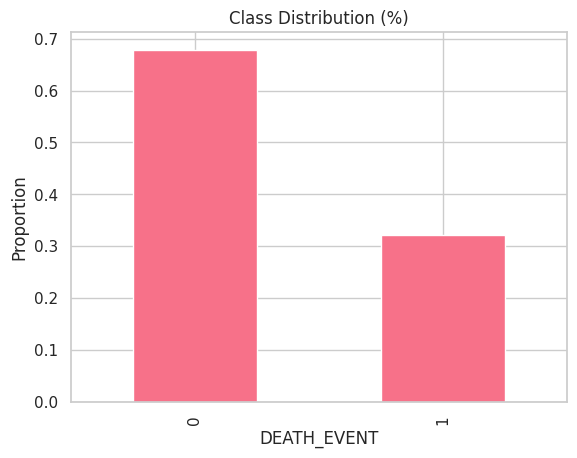

In [ ]:
# --- Visualize Original Class Distribution ---
cleaned_df['DEATH_EVENT'].value_counts(normalize=True).plot(
    kind='bar',
    title='Class Distribution (%)',
    ylabel='Proportion'
)
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE

# --- Apply SMOTE for Balancing ---
def upscale_with_smote(df: pd.DataFrame, target_column: str = 'DEATH_EVENT', n_samples_per_class: int = 10000):
    print("🚀 Upscaling using SMOTE...")

    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # SMOTE sampling strategy
    smote = SMOTE(sampling_strategy={0: n_samples_per_class, 1: n_samples_per_class}, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Reconstruct DataFrame
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled

    print(f"✅ Resampled dataset shape: {df_resampled.shape}")
    print(df_resampled[target_column].value_counts())

    return df_resampled

df_upscaled = upscale_with_smote(selected_df)

🚀 Upscaling using SMOTE...
✅ Resampled dataset shape: (20000, 11)
DEATH_EVENT
1    10000
0    10000
Name: count, dtype: int64


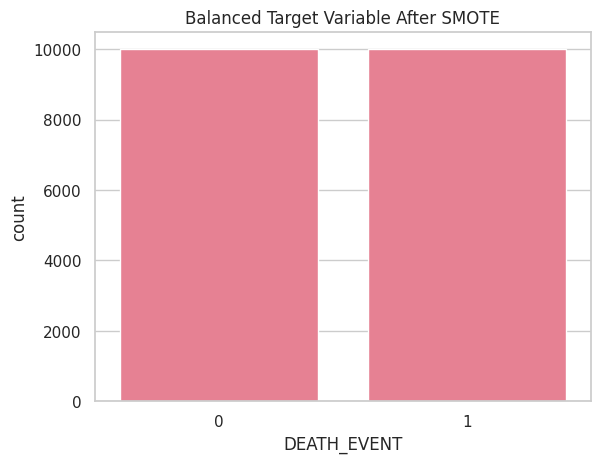

                            count           mean           std      min  \
age                       20000.0      62.219813     10.592427     40.0   
anaemia                   20000.0       0.201800      0.401354      0.0   
creatinine_phosphokinase  20000.0     553.826400    796.829769     23.0   
ejection_fraction         20000.0      36.397850     10.104953     14.0   
high_blood_pressure       20000.0       0.135850      0.342638      0.0   
platelets                 20000.0  260574.425094  91741.562847  25100.0   
serum_creatinine          20000.0       1.517184      0.993302      0.5   
serum_sodium              20000.0     135.832800      3.694432    113.0   
smoking                   20000.0       0.097500      0.296645      0.0   
time                      20000.0     114.494600     67.957725      4.0   
DEATH_EVENT               20000.0       0.500000      0.500013      0.0   

                                    25%            50%            75%  \
age                       

In [ ]:
# --- Visualize Resampled Distribution ---
sns.countplot(x='DEATH_EVENT', data=df_upscaled)
plt.title("Balanced Target Variable After SMOTE")
plt.show()

# Optionally inspect feature stats
print(df_upscaled.describe().T)

# 🔀 Train-Test Split (70:30)
> Split the dataset into 70% training and 30% testing sets.
> A commonly used ratio that balances training data sufficiency with reliable model evaluation.


In [ ]:
from sklearn.model_selection import train_test_split

# --- Train-Test Split (Stratified) ---
X = df_upscaled.drop(columns='DEATH_EVENT').values
y = df_upscaled['DEATH_EVENT'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
from sklearn.preprocessing import StandardScaler

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Artificial Neural Network (ANN) Modeling 🤖🧠💡


=== Training the ANN ===
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6811 - auc: 0.7403 - loss: 0.5900 - precision: 0.7030 - recall: 0.6249 - val_accuracy: 0.8753 - val_auc: 0.9504 - val_loss: 0.2958 - val_precision: 0.8763 - val_recall: 0.8740
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8527 - auc: 0.9306 - loss: 0.3378 - precision: 0.8501 - recall: 0.8558 - val_accuracy: 0.8835 - val_auc: 0.9587 - val_loss: 0.2632 - val_precision: 0.8834 - val_recall: 0.8837
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8752 - auc: 0.9450 - loss: 0.3000 - precision: 0.8689 - recall: 0.8882 - val_accuracy: 0.8920 - val_auc: 0.9623 - val_loss: 0.2488 - val_precision: 0.8798 - val_recall: 0.9080
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8823 - auc: 0.9501 - loss: 0.2876 - precision: 0.8706 - recall: 0.8980 - val_accuracy: 0.8962 - val_auc: 0.9648 - val_loss: 0.2399 - val_precision: 0.8908 - val_recall: 0.9030
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 

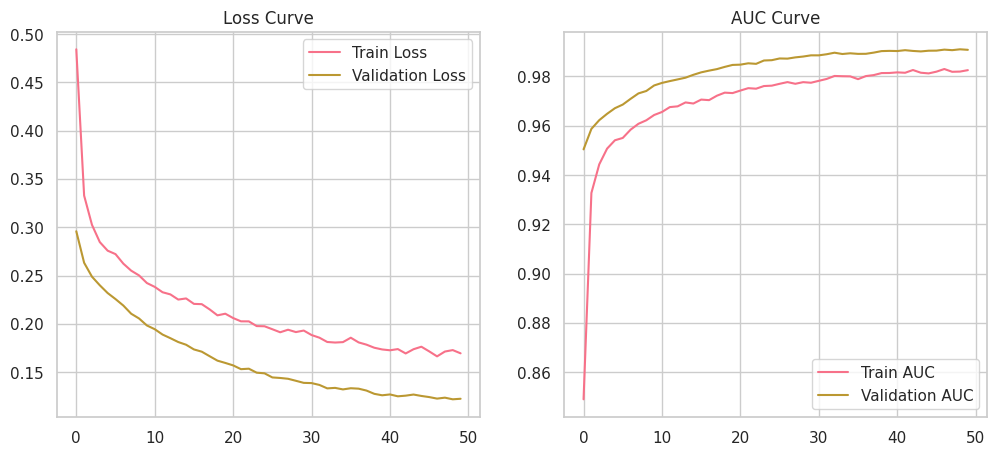

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build Artificial Neural Network (ANN)
model = Sequential([
    Dense(22, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(11, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Train the model (backpropagation)
print("\n=== Training the ANN ===")
history = model.fit(
    X_train_scaled, y_train,  # Using resampled training data
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('AUC Curve')
plt.legend()
plt.show()


=== Model Predictions ===
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

=== Classification Report ===
              precision    recall  f1-score   support

    Survived       0.96      0.95      0.95      3000
    Deceased       0.95      0.96      0.96      3000

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000


=== Confusion Matrix ===


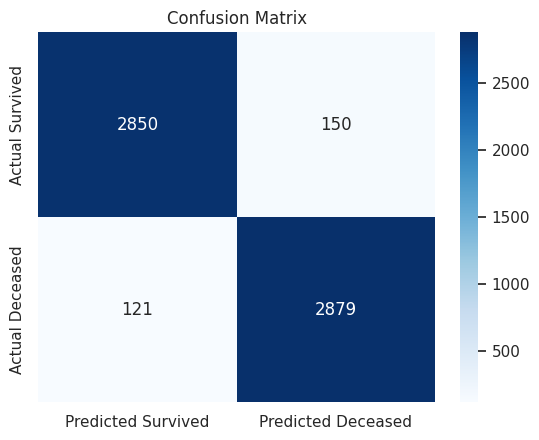


ROC-AUC Score: 0.9912


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score, make_scorer

# Make predictions
print("\n=== Model Predictions ===")
y_pred_proba = model.predict(X_test_scaled).flatten()
y_pred_class = (y_pred_proba > 0.55).astype(int)

# Evaluation Metrics
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred_class, target_names=['Survived', 'Deceased']))

print("\n=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Survived', 'Predicted Deceased'],
            yticklabels=['Actual Survived', 'Actual Deceased'])
plt.title('Confusion Matrix')
plt.show()

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")


In [ ]:
# --- Save Training History to CSV ---
print("\n=== Saving Training History to CSV ===")

# Extract history dictionary
history_dict = history.history

# Convert to DataFrame
history_df = pd.DataFrame(history_dict)

# Add epoch index (optional)
history_df['epoch'] = history_df.index + 1

# Save to CSV
history_df.to_csv('training_history.csv', index=False)

# Optional: Display first few rows
print(history_df.head())



=== Saving Training History to CSV ===
   accuracy       auc      loss  precision    recall  val_accuracy   val_auc  \
0  0.763857  0.848954  0.484275   0.773549  0.746143      0.875333  0.950414   
1  0.857429  0.932717  0.332768   0.852097  0.865000      0.883500  0.958728   
2  0.873643  0.944322  0.302490   0.864733  0.885857      0.892000  0.962267   
3  0.883429  0.950711  0.284592   0.872054  0.898714      0.896167  0.964846   
4  0.887571  0.954102  0.275718   0.876492  0.902286      0.902500  0.967123   

   val_loss  val_precision  val_recall  epoch  
0  0.295817       0.876337    0.874000      1  
1  0.263198       0.883372    0.883667      2  
2  0.248783       0.879845    0.908000      3  
3  0.239869       0.890825    0.903000      4  
4  0.231836       0.889642    0.919000      5  


In [ ]:
from google.colab import files
files.download('training_history.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
188/188 ━━━━━━━━━━━━━━━━━━━

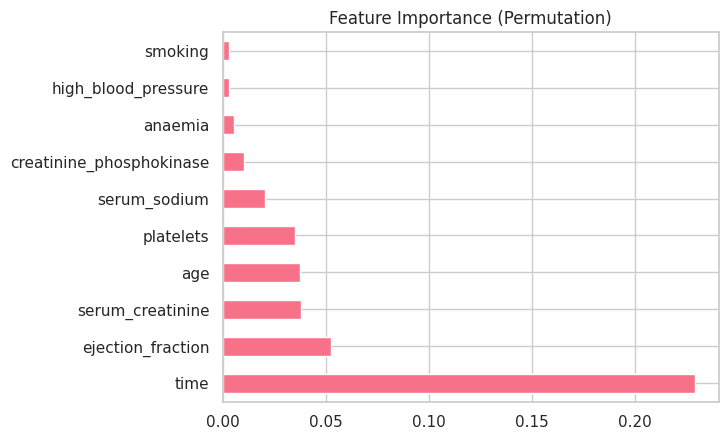

In [ ]:
from sklearn.inspection import permutation_importance

# Feature Importance (Permutation Importance)
# Store column names before converting to NumPy arrays
feature_names = df_upscaled.drop(columns='DEATH_EVENT').columns.tolist()

def permutation_importance(model, X, y, feature_names, metric=roc_auc_score, n_repeats=5):
    baseline_score = metric(y, model.predict(X).flatten())
    results = {}

    for i in range(X.shape[1]):
        temp = X.copy()
        scores = []
        for _ in range(n_repeats):
            temp[:, i] = np.random.permutation(temp[:, i])
            scores.append(metric(y, model.predict(temp).flatten()))
        results[feature_names[i]] = baseline_score - np.mean(scores)

    return pd.Series(results).sort_values(ascending=False)

# Only show importance if not too many features
if len(feature_names) <= 20:
    importance = permutation_importance(model, X_test_scaled, y_test, feature_names)
    importance.plot(kind='barh', title='Feature Importance (Permutation)')
    plt.show()
else:
    print("Too many features to display importance plot")



📊 Trial 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 3/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 4/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 5/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 6/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 7/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 8/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 9/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 10/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 11/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Trial 12/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Trial 13/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 14/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 15/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 16/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 17/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 18/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 19/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 20/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 21/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 22/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📊 Trial 23/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 24/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 25/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 26/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 27/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 28/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 29/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

📊 Trial 30/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


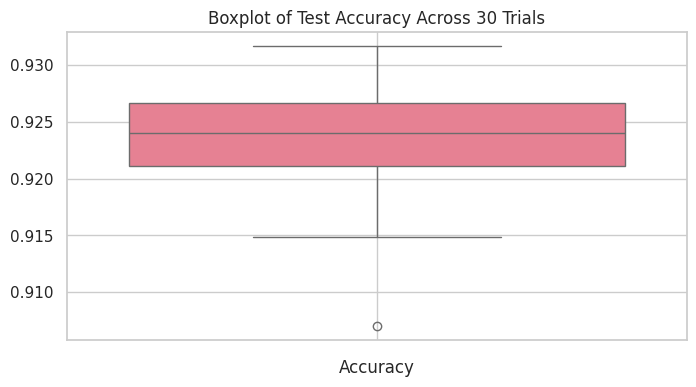


=== Feature Summary ===
                     count           mean           std      min  \
time               20000.0     114.494600     67.957725      4.0   
ejection_fraction  20000.0      36.397850     10.104953     14.0   
age                20000.0      62.219813     10.592427     40.0   
platelets          20000.0  260574.425094  91741.562847  25100.0   
serum_creatinine   20000.0       1.517184      0.993302      0.5   

                             25%            50%            75%       max  
time                   55.000000     107.000000     170.000000     285.0  
ejection_fraction      29.000000      36.000000      42.000000      80.0  
age                    54.203787      61.475981      69.414529      95.0  
platelets          209268.911975  262284.347797  304803.151333  850000.0  
serum_creatinine        1.000000       1.199838       1.699216       9.4  

=== Average Classification Report ===

📄 Survived (0):
Precision: 0.932
Recall:    0.914
F1-Score:  0.923

📄 Deceas

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from collections import defaultdict

# --- Parameters ---
selected_features = ['time', 'ejection_fraction', 'age', 'platelets', 'serum_creatinine']
target_column = 'DEATH_EVENT'
n_trials = 30
acc_list = []
report_list = []

# --- Run multiple trials ---
for i in range(n_trials):
    print(f"\n📊 Trial {i+1}/{n_trials}")

    # 1. Train-Test Split
    X = df_upscaled[selected_features]
    y = df_upscaled[target_column]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=np.random.randint(10000)
    )

    # 2. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Build model
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # 4. Train model
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=50,
        batch_size=16,
        verbose=0,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
    )

    # 5. Evaluate model
    y_pred_prob = model.predict(X_test_scaled).flatten()
    y_pred = (y_pred_prob > 0.55).astype(int)

    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc)

    report = classification_report(y_test, y_pred, output_dict=True)
    report_list.append(report)

# --- Accuracy Boxplot ---
plt.figure(figsize=(8, 4))
sns.boxplot(acc_list)
plt.title("Boxplot of Test Accuracy Across 30 Trials")
plt.xlabel("Accuracy")
plt.grid(True)
plt.show()

# --- Descriptive Stats of Features ---
print("\n=== Feature Summary ===")
print(df_upscaled[selected_features].describe().T)

# --- Average Classification Report ---
print("\n=== Average Classification Report ===")

def average_reports(report_list):
    avg = defaultdict(float)
    for report in report_list:
        for cls in ['0', '1']:  # 0 = Survived, 1 = Deceased
            for metric in ['precision', 'recall', 'f1-score']:
                key = f"{cls}_{metric}"
                avg[key] += report[cls][metric]
    for k in avg:
        avg[k] /= len(report_list)
    return avg

avg_metrics = average_reports(report_list)

print(f"\n📄 Survived (0):")
print(f"Precision: {avg_metrics['0_precision']:.3f}")
print(f"Recall:    {avg_metrics['0_recall']:.3f}")
print(f"F1-Score:  {avg_metrics['0_f1-score']:.3f}")

print(f"\n📄 Deceased (1):")
print(f"Precision: {avg_metrics['1_precision']:.3f}")
print(f"Recall:    {avg_metrics['1_recall']:.3f}")
print(f"F1-Score:  {avg_metrics['1_f1-score']:.3f}")

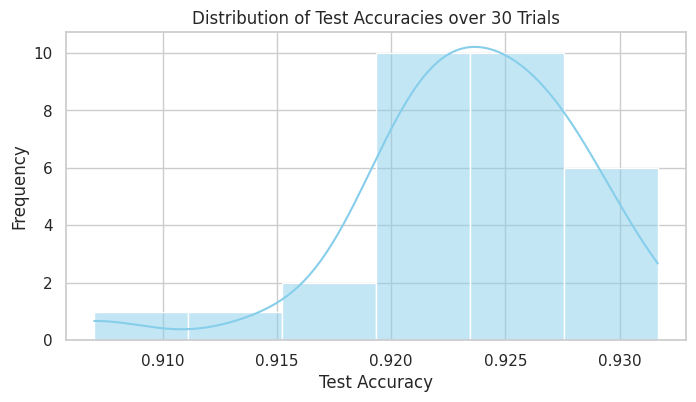

In [ ]:
# --- Distribution Plot of Accuracies ---
plt.figure(figsize=(8, 4))
sns.histplot(acc_list, bins=6, kde=True, color='skyblue')
plt.title('Distribution of Test Accuracies over 30 Trials')
plt.xlabel('Test Accuracy')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

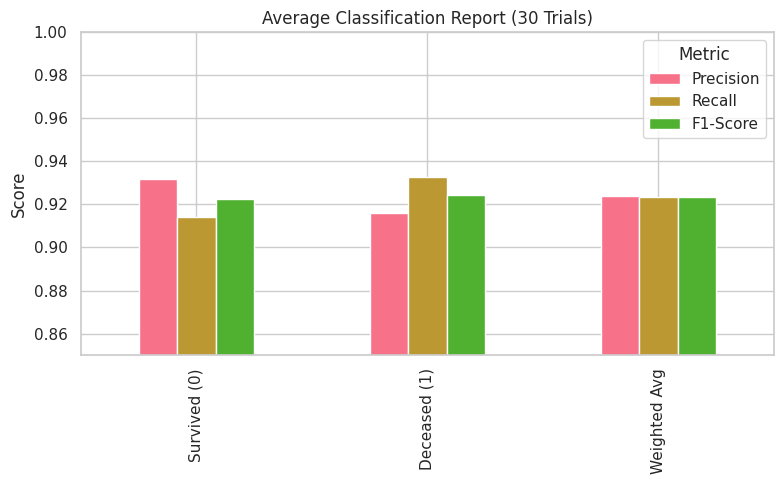

In [ ]:
# --- Prepare Average Classification Report for Plotting ---
avg_df = pd.DataFrame({
    'Precision': [avg_metrics['0_precision'], avg_metrics['1_precision']],
    'Recall': [avg_metrics['0_recall'], avg_metrics['1_recall']],
    'F1-Score': [avg_metrics['0_f1-score'], avg_metrics['1_f1-score']]
}, index=['Survived (0)', 'Deceased (1)'])

# Optional: Add weighted average
weighted_precision = np.mean([r['weighted avg']['precision'] for r in report_list])
weighted_recall = np.mean([r['weighted avg']['recall'] for r in report_list])
weighted_f1 = np.mean([r['weighted avg']['f1-score'] for r in report_list])
avg_df.loc['Weighted Avg'] = [weighted_precision, weighted_recall, weighted_f1]

# --- Bar Plot of Average Classification Report ---
avg_df.plot(kind='bar', figsize=(8, 5))
plt.title("Average Classification Report (30 Trials)")
plt.ylim(0.85, 1.00)
plt.ylabel("Score")
plt.xlabel("")
plt.legend(title="Metric")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
